# Import the Dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving spam.csv to spam.csv


# Import required library

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers 

# Read dataset and do pre-processing

In [ ]:
df = pd.read_csv(r"/content/spam.csv", encoding="latin-1")

In [ ]:
df.head() # an overview

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


**Since the given dataset has three Unnamed columns that we don't need, we will drop them and also our label is in string form -> spam and ham, we will map them in numerical form.**

In [ ]:
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
df = df.rename(columns={'v1':'label', 'v2':'Text'})
df['label_in_num'] = df['label'].map({'ham':0,'spam':1})
df.head()

,label,Text,label_in_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


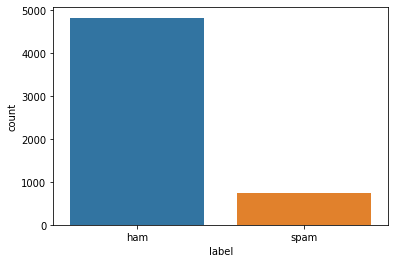

In [ ]:
sns.countplot(x=df['label']) # countplot for label

In [ ]:
df['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

Text(0.5, 0, 'Text length')

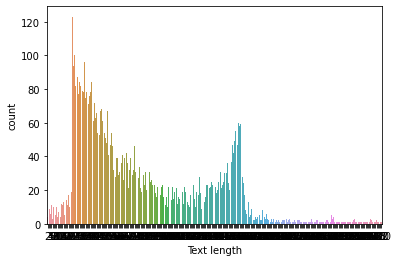

In [ ]:
sns.countplot(x=[len(df.loc[i]['Text']) for i in range(len(df))])
plt.xlabel('Text length')

In [ ]:
text_words_lengths = [len(df.loc[i]['Text'].split()) for i in range(0, len(df))]
total_length = np.sum(text_words_lengths)
text_words_mean = int(np.mean(text_words_lengths))
print('we have ' + str(total_length) + ' words in our Dataframe')
print('the average word count in every scentence is ' + str(text_words_mean))
text_words_lengths[:5], total_length, text_words_mean

we have 86335 words in our Dataframe
the average word count in every scentence is 15


([20, 6, 28, 11, 13], 86335, 15)

# Train & Test Split

In [ ]:
from sklearn.model_selection import train_test_split
X, y = np.asanyarray(df['Text']), np.asanyarray(df['label_in_num'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)
len(X_train), len(X_test), X_train[:2], y_train[:2]

(4457, 1115, array(['Kallis wont bat in 2nd innings.',
        'Ringtone Club: Get the UK singles chart on your mobile each week and choose any top quality ringtone! This message is free of charge.'],
       dtype=object), array([0, 1]))

**Helper Functions**

Text vectorization is the process of converting text into a numerical representation. Example: Bag of words frequency, Binary Term frequency, etc.; A word embedding is a learned representation of text in which words with related meanings have similar representations. Each word is assigned to a single vector, and the vector values are learned like that of a neural network.Now, we’ll create a custom text vectorization layer using TensorFlow.

In [ ]:
MAXTOKENS = total_length #maximum size of the vocabulary which was found earlier
OUTPUTLEN = text_words_mean #length to which the sentences should be padded irrespective of the sentence length.
text_vec = layers.TextVectorization(
    max_tokens=MAXTOKENS,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=OUTPUTLEN
)
text_vec.adapt(X_train)

In [ ]:
#input_dim is the size of vocabulary
#output_dim is the dimension of the embedding layer i.e, the size of the vector in which the words will be embedded
#input_length is the length of input sequences
embedding_layer = layers.Embedding(
    input_dim=MAXTOKENS,
    output_dim=128,
    embeddings_initializer='uniform',
    input_length=OUTPUTLEN
)

# Create Model

In [ ]:
input_layer = layers.Input(shape=(1,), dtype=tf.string) # Input layer, string type(text)
vec_layer = text_vec(input_layer) # text vectorization layer(built previous lines)
embedding_layer_model = embedding_layer(vec_layer) # word embedding layer
bi_lstm = layers.Bidirectional(layers.LSTM(64, activation='tanh', return_sequences=True))(embedding_layer_model) # Bidirectional-LSTM, 64 units
lstm = layers.Bidirectional(layers.LSTM(64))(bi_lstm)
flatten = layers.Flatten()(lstm) # Flatten layer for enering in dense layers
dropout = layers.Dropout(.1)(flatten) # drop out layer
x = layers.Dense(32, activation='relu')(dropout) # Dense layer
output_layer = layers.Dense(1, activation='sigmoid')(x) # output layer
model_2 = keras.Model(input_layer, output_layer) # final model

# Add Layers (LSTM, Dense-(Hidden Layers), Output)

In [ ]:
# Input layer
input_layer = layers.Input(shape=(1,), dtype=tf.string)
# Text Vectorizatino layer
vec_layer = text_vec(input_layer)
# Embedding layer
embedding_layer_model = embedding_layer(vec_layer)
# Global Average Pooling layer
x = layers.GlobalAveragePooling1D()(embedding_layer_model)
# Flatten layer for Dense layers
x = layers.Flatten()(x)
# 32 units dense layer
x = layers.Dense(32, activation='relu')(x)
# output layer with sigmoid activation function
output_layer = layers.Dense(1, activation='sigmoid')(x)
# final model
model_1 = keras.Model(input_layer, output_layer)

# Compile the Model, Fit the Model

In [ ]:
def compile_model(model):
    model.compile(optimizer=keras.optimizers.Adam(),
                 loss=keras.losses.BinaryCrossentropy(),
                 metrics=['accuracy'])    
def fit_model(model, epochs, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    history = model.fit(X_train,
              y_train,
             epochs=epochs,
             validation_data=(X_test, y_test),
             validation_steps=int(0.2*len(X_test)))
    return history

In [ ]:
compile_model(model_2) # compile the model
history_2 = fit_model(model_2, epochs=5) # fit the model

Epoch 1/5
140/140 [==============================] - 31s 167ms/step - loss: 0.1683 - accuracy: 0.9453 - val_loss: 0.0956 - val_accuracy: 0.9668
Epoch 2/5
140/140 [==============================] - 22s 158ms/step - loss: 0.0286 - accuracy: 0.9930 - val_loss: 0.0566 - val_accuracy: 0.9821
Epoch 3/5
140/140 [==============================] - 23s 163ms/step - loss: 0.0120 - accuracy: 0.9960 - val_loss: 0.0750 - val_accuracy: 0.9821
Epoch 4/5
140/140 [==============================] - 22s 154ms/step - loss: 9.8526e-04 - accuracy: 0.9998 - val_loss: 0.0952 - val_accuracy: 0.9830
Epoch 5/5
140/140 [==============================] - 22s 154ms/step - loss: 6.7317e-05 - accuracy: 1.0000 - val_loss: 0.1042 - val_accuracy: 0.9830


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
def evaluate_model(model, X, y):
    y_preds = np.round(model.predict(X))
    accuracy = accuracy_score(y, y_preds)
    precision = precision_score(y, y_preds)
    recall = recall_score(y, y_preds)
    f1 = f1_score(y, y_preds)
    model_results_dict = {'accuracy':accuracy,
                         'precision':precision,
                         'recall':recall,
                         'f1-score':f1}
    return model_results_dict

# Saving and testing the model

In [ ]:
model_2.save('spam')

In [ ]:
model_2.evaluate(X_test, y_test)

35/35 [==============================] - 2s 13ms/step - loss: 0.1042 - accuracy: 0.9830


[0.10417114198207855, 0.9829596281051636]

In [ ]:
print(evaluate_model(model_2,X_test, y_test))

35/35 [==============================] - 2s 11ms/step
{'accuracy': 0.9829596412556054, 'precision': 0.9310344827586207, 'recall': 0.9375, 'f1-score': 0.9342560553633218}
